In [1]:
!git clone https://github.com/AlinaGalenina/ML_HOMEWORK4

fatal: destination path 'ML_HOMEWORK4' already exists and is not an empty directory.


In [2]:
! cd ML_HOMEWORK4/ && wget https://raw.githubusercontent.com/davda54/sam/main/sam.py

--2021-01-13 14:02:27--  https://raw.githubusercontent.com/davda54/sam/main/sam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1985 (1.9K) [text/plain]
Saving to: ‘sam.py.2’

sam.py.2            100%[===================>]   1.94K  --.-KB/s    in 0s      

2021-01-13 14:02:27 (40.8 MB/s) - ‘sam.py.2’ saved [1985/1985]



In [1]:
!pip3 install -r ML_HOMEWORK4/requirements.txt

  Using cached https://files.pythonhosted.org/packages/24/a8/5133f51967fb21e46ee50831c3f5dda49e976b7f915408d670b1603d41d6/astroid-2.4.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/56/c5/97a972202414c79c28814b1450a31a89777638fb3524e8b5b686a5436abe/ipykernel-5.4.2-py3-none-any.whl
ERROR: Could not find a version that satisfies the requirement ipython==7.19.0 (from -r ML_HOMEWORK4/requirements.txt (line 13)) (from versions: 0.10, 0.10.1, 0.10.2, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.13.2, 1.0.0, 1.1.0, 1.2.0, 1.2.1, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.2.2, 3.2.3, 4.0.0b1, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.1.0rc1, 4.1.0rc2, 4.1.0, 4.1.1, 4.1.2, 4.2.0, 4.2.1, 5.0.0b1, 5.0.0b2, 5.0.0b3, 5.0.0b4, 5.0.0rc1, 5.0.0, 5.1.0, 5.2.0, 5.2.1, 5.2.2, 5.3.0, 5.4.0, 5.4.1, 5.5.0, 5.6.0, 5.7.0, 5.8.0, 5.9.0, 5.10.0, 6.0.0rc1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.3.0, 6.3.1, 6.4.0, 6.5.0, 7.0.0b1, 7.0.0rc1, 7.0.0, 7.0.1, 7.1.0, 7.1.1, 7.2.0, 7.3.0, 

In [161]:
import matplotlib
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import sys
from tqdm.notebook import tqdm, trange
from time import sleep

from ML_HOMEWORK4.sam import SAM
from ML_HOMEWORK4.zoo import models
from ML_HOMEWORK4.common.data_loader import DataLoader
from ML_HOMEWORK4.util import visualize_model

## Device configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Configuration

In [193]:
num_epochs = 90
num_classes = 10
batch_size = 256
learning_rate = 0.001
momentum = 0.9


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Pad(3),
    transforms.RandomCrop(32),
    transforms.RandomAffine(degrees=2),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

## Load data

In [187]:
data_loader = DataLoader()
data_loader.set_transform(transform)
train_data = data_loader.get_train_data(batch_size)
test_data = data_loader.get_test_data(batch_size)

Files already downloaded and verified


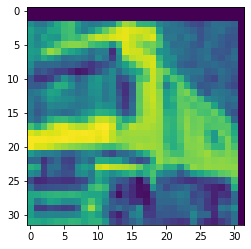

In [188]:
import matplotlib.pyplot as plt
plt.ion()
plt.imshow(train_data.dataset[0][0][0, :, :])
plt.imshow(train_data.dataset[1][0][0, :, :])

In [125]:
print(train_data.__dict__)

{'dataset': Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Pad(padding=2, fill=0, padding_mode=constant)
               RandomCrop(size=(32, 32), padding=None)
               RandomAffine(degrees=[-5.0, 5.0])
               ToTensor()
           ), 'num_workers': 0, 'prefetch_factor': 2, 'pin_memory': False, 'timeout': 0, 'worker_init_fn': None, '_DataLoader__multiprocessing_context': None, '_dataset_kind': 0, 'batch_size': 512, 'drop_last': False, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x7f4a9845cb00>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x7f4a9829ecf8>, 'generator': None, 'collate_fn': <function default_collate at 0x7f4abaab5730>, 'persistent_workers': False, '_DataLoader__initialized': True, '_IterableDataset_len_called': None, '_iterator': None}


In [20]:
import inspect
models_ = []
for name, obj in inspect.getmembers(models):
    if inspect.isclass(obj) and inspect.getmodule(obj).__name__.split(".")[-1] == "models":
        models_.append(obj)
        # print (obj)
# print(models.__dict__)

## Train model

In [175]:
def train_model(model):
    losses = []
    epochs = []
    total_step = len(train_data)
    with tqdm(total=num_epochs, file=sys.stdout) as pbar:
      for epoch in range(num_epochs):
        glloss = 0
        for i, (images, labels) in enumerate(train_data):
            # Place training batch onto the appropriate device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted y by passing x to the model.
            outputs = model(images)

            # Compute loss.
            loss = loss_function(outputs, labels)

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers(i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()

            glloss = loss.item()
            # if (i + 1) % 100 == 0:
            #   print("glloss")
              # tqdm.write('\nEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

        # Save the model checkpoint
        epochs.append(epoch + 1)
        print(f"Current epoch is {epoch + 1} current loss is {glloss}")
        pbar.update(1)
        sleep(1)
        losses.append(glloss)
        torch.save(model.state_dict(), 'model.ckpt')

    return losses, epochs

## Evaluate model

In [183]:
def eval_model(model):
    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance; dropout disabled)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_data:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_data), 100 * correct / total))


    # visualize_model(model, device, test_data, num_images=15,
    #                 class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    #                 )
    # matplotlib.pyplot.waitforbuttonpress()

## Pipeline

Current epoch is 1 current loss is 0.9862702488899231
Current epoch is 2 current loss is 0.9306883811950684
Current epoch is 3 current loss is 0.8560452461242676
Current epoch is 4 current loss is 0.7114583849906921
Current epoch is 5 current loss is 0.9856897592544556
Current epoch is 6 current loss is 0.8439309000968933
Current epoch is 7 current loss is 0.5756446719169617
Current epoch is 8 current loss is 0.4527130722999573
Current epoch is 9 current loss is 0.4379842281341553
Current epoch is 10 current loss is 0.8357052803039551
Current epoch is 11 current loss is 0.5186491012573242
Current epoch is 12 current loss is 0.594322919845581
Current epoch is 13 current loss is 0.616470217704773
Current epoch is 14 current loss is 0.8023201823234558
Current epoch is 15 current loss is 0.5981191396713257
Current epoch is 16 current loss is 0.7365468740463257
Current epoch is 17 current loss is 0.4252590239048004
Current epoch is 18 current loss is 0.4582740366458893
Current epoch is 19 c

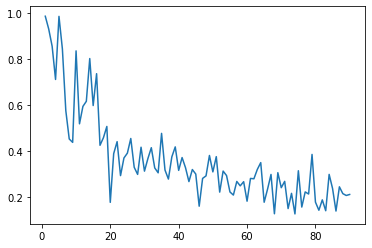

In [194]:
import matplotlib.pyplot as plt

for model in models_:
    # print(f"\nCurrent model is {model.__name__}")
    model = model()
    # print(model)
    model.to(device)

    loss_function = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
                                 
    losses, epochs = train_model(model)
    # print(losses)
    plt.plot(epochs, losses)
    eval_model(model)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


78.66% - baseline

84.85% - top

86.09% - 70 iter

86.42% - 90 iter